In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import numpy as np
import pandas as pd
import unicodedata
import string
import re
import random
import torch

In [3]:
print(torch.__version__)

1.4.0


In [0]:
data = pd.read_csv("drive/My Drive/machine_tran/data1.csv")

In [0]:
eng = data['en'][:2000].to_list()

In [0]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {"<blank>":0, "SOS":1,"EOS":2}
        self.word2count = {}
        self.index2word = {0:"<blank>", 1: "SOS", 2: "EOS"}
        self.n_words = 3  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [0]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [0]:
eng_lang = Lang("eng")

In [0]:
en_data  = []
for sent in eng:

  sent  = normalizeString(sent)
  en_data.append(sent)
  eng_lang.addSentence(sent)

In [11]:
eng_lang.n_words

4581

In [12]:
en_data[0]

'the priest will then examine the contaminated item after it has been thoroughly washed . if the appearance of the contamination has not changed even if the disease has not spread it is unclean . you should burn it in the fire because it has been eaten away either from its underside or from its outside .'

In [0]:
def tokenize(lang,sentence):
    
    sent = "SOS" + " " + sentence + " " + "EOS"
    return [lang.word2index[word] for word in sent.split(' ')]

In [0]:
en_token = list(map(lambda x: tokenize(eng_lang, x), en_data))

In [0]:
word_len = list(map(lambda x: len(x), en_token))

In [0]:
MAX_LENGTH = max(word_len)

In [17]:
MAX_LENGTH

80

In [0]:
token_pad = np.zeros((len(en_token), MAX_LENGTH))

In [0]:
for i,v in enumerate(en_token):
    
    for j, token in enumerate(v):
        
        token_pad[i,j] = token

In [20]:
token_pad[0]

array([ 1.,  3.,  4.,  5.,  6.,  7.,  3.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17.,  3., 18., 19.,  3., 20., 12., 21., 22., 23.,
       17.,  3., 24., 12., 21., 25., 11., 26., 27., 16., 28., 29., 30.,
       11., 31.,  3., 32., 33., 11., 12., 13., 34., 35., 36., 37., 38.,
       39., 40., 37., 38., 41., 16.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.])

In [0]:
valid = token_pad[:800]
train = token_pad[800:]

In [0]:
from torch.utils.data import TensorDataset, DataLoader

In [0]:
train_data = TensorDataset(torch.from_numpy(train).long())

In [0]:
valid_data = TensorDataset(torch.from_numpy(valid).long())

In [0]:
batch_size = 100

train_loader= DataLoader(train_data,shuffle=True,batch_size=batch_size,)
valid_loader =DataLoader(valid_data,shuffle=True,batch_size=batch_size,)

In [26]:
dataiter = iter(train_loader)
sample_x= dataiter.next()[0]

sample_x.shape

torch.Size([100, 80])

In [27]:
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

In [0]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [0]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [0]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

In [0]:
class Decoder(nn.Module):

  def __init__(self, layer, N):

    super(Decoder, self).__init__()
    self.layers = clones(layer, N)
    self.norm = LayerNorm(layer.size)

  def forward(self,x, tgt_mask):

    for layer in self.layers:
      x = layer(x, tgt_mask)
    return self.norm(x)

In [0]:
class DecoderLayer(nn.Module):

  def __init__(self, size, self_attn, feed_forward, dropout):
    super(DecoderLayer, self).__init__()
    self.size = size
    self.self_attn = self_attn
    self.feed_forward = feed_forward
    self.sublayer = clones(SublayerConnection(size, dropout), 2)

  def forward(self, x, tgt_mask):

    x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
    return self.sublayer[1](x, self.feed_forward)

In [0]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

In [0]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [0]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

In [0]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.gelu(self.w_1(x))))

In [0]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

In [0]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0., max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0., d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

In [0]:
class GP(nn.Module):

  def __init__(self, decoder, tgt_embed, generator):
    super(GP, self).__init__()
    self.decoder = decoder
    self.embed = tgt_embed
    self.generator = generator

  def forward(self, x, x_mask):

    x = self.embed(x)
    x =  self.decoder(x,x_mask)

    return x

In [0]:
def make_model(eng_vocab, N=12, d_model=768, d_ff=3072, h=12, dropout=0.1):

  c = copy.deepcopy
  attn = MultiHeadedAttention(h,d_model)
  ff   = PositionwiseFeedForward(d_model, d_ff, dropout)
  position = PositionalEncoding(d_model, dropout)


  model = GP(
      Decoder(DecoderLayer(d_model, c(attn), c(ff), dropout), N),
      nn.Sequential(Embeddings(d_model, eng_vocab), c(position)),
      Generator(d_model, eng_vocab)
  )

  for p in model.parameters():
    if p.dim() > 1:
      nn.init.xavier_uniform(p)
  return model

In [42]:
tmp_model = make_model(10,2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


In [43]:
tmp_model

GP(
  (decoder): Decoder(
    (layers): ModuleList(
      (0): DecoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=768, out_features=768, bias=True)
            (1): Linear(in_features=768, out_features=768, bias=True)
            (2): Linear(in_features=768, out_features=768, bias=True)
            (3): Linear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=768, out_features=3072, bias=True)
          (w_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): SublayerConnection(
            (norm): LayerNorm()
           

In [0]:
class Batch:

  def __init__(self, trg, pad=0):

    self.trg = trg[:, :-1]
    self.trg_y = trg[:, 1:]

    self.trg_mask = self.make_std_mask(self.trg,pad)

    self.ntokens = (self.trg_y !=pad).data.sum()

  @staticmethod
  def make_std_mask(tgt, pad):
    tgt_mask = (tgt != pad).unsqueeze(-2)
    tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
    return tgt_mask


In [0]:
def run_epoch(data_iter, model, loss_compute):

  start = time.time()
  total_tokens = 0
  total_loss = 0
  tokens = 0

  for i , data in enumerate(data_iter):

    trg = data[0]

    batch = Batch(trg.cuda())

    out = model.forward(batch.trg, batch.trg_mask)

    loss = loss_compute(out, batch.trg_y, batch.ntokens)

    total_loss += loss
    total_tokens += batch.ntokens
    tokens += batch.ntokens

    if i % 50 == 1:

      elapsed = time.time() - start
      print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
              (i, loss / batch.ntokens, tokens / elapsed))
      start = time.time()
      tokens = 0
  return total_loss / total_tokens

In [0]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

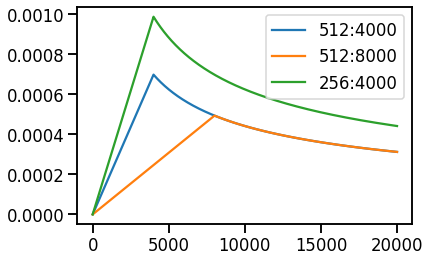

In [47]:
# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 1, 4000, None), 
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])
None

In [0]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

In [0]:
class SimpleLossCompute:
    "A simple loss compute and train function."
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.item() * norm

In [0]:
def greedy_decode(model, src, max_len):
    for i in range(max_len-1):
        out = model(Variable(src), 
                    Variable(subsequent_mask(src.size(1)).type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        src = torch.cat([src, 
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return src

In [52]:
pad_idx = eng_lang.word2index["<blank>"]
model = make_model(eng_lang.n_words)
model.cuda()
criterion = LabelSmoothing(size=eng_lang.n_words,padding_idx=pad_idx,smoothing=0.1)
criterion.cuda()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


LabelSmoothing(
  (criterion): KLDivLoss()
)

In [53]:
model_opt = NoamOpt(model.embed[0].d_model, 1, 2000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

for epoch in range(70):
  model.train()
  
    
  run_epoch(train_loader,model,
           SimpleLossCompute(model.generator,criterion,model_opt))
  model.eval()
  print(run_epoch(valid_loader,model,
           SimpleLossCompute(model.generator,criterion,None)))

Epoch Step: 1 Loss: 7.490267 Tokens per Sec: 3238.666016
Epoch Step: 1 Loss: 7.039496 Tokens per Sec: 3925.093994
tensor(7.0439, device='cuda:0')
Epoch Step: 1 Loss: 7.062612 Tokens per Sec: 3727.297119
Epoch Step: 1 Loss: 6.565397 Tokens per Sec: 3838.799316
tensor(6.5669, device='cuda:0')
Epoch Step: 1 Loss: 6.594292 Tokens per Sec: 3676.047119
Epoch Step: 1 Loss: 6.203159 Tokens per Sec: 4143.526367
tensor(6.2170, device='cuda:0')
Epoch Step: 1 Loss: 6.270242 Tokens per Sec: 3604.899170
Epoch Step: 1 Loss: 5.953823 Tokens per Sec: 3873.957764
tensor(5.9930, device='cuda:0')
Epoch Step: 1 Loss: 6.028389 Tokens per Sec: 3783.276611
Epoch Step: 1 Loss: 5.820293 Tokens per Sec: 4017.642334
tensor(5.8395, device='cuda:0')
Epoch Step: 1 Loss: 5.889585 Tokens per Sec: 3700.244873
Epoch Step: 1 Loss: 5.701013 Tokens per Sec: 3970.195312
tensor(5.6939, device='cuda:0')
Epoch Step: 1 Loss: 5.701090 Tokens per Sec: 3835.337891
Epoch Step: 1 Loss: 5.507428 Tokens per Sec: 3867.852783
tensor(5.5

In [0]:
def generate_word(words, max_len, model=model):

  token_word = torch.Tensor([eng_lang.word2index[word] for word in words]).long()
  tok_word = token_word[None, ...]

  model.eval()

  out = greedy_decode(model, tok_word.cuda(), max_len=max_len)

  rslt = [eng_lang.index2word[item.item()] for item in out.data[0]]

  return " ".join(rslt)

In [86]:
generate_word("SOS father".split(), 20)

'SOS father of the fatherless and a protector of widows is god in his holy dwelling . EOS in his holy'